# Exercício 1 - Titanic

Consideta o ficheiro train.csv, que contém o famoso dataset do Titanic, com informações de passageiros e se sobreviveram ou não. Eis um resumo completo:
| Coluna       | Tipo    | Descrição                                                         |
|--------------|---------|-------------------------------------------------------------------|
| PassengerId  | int64   | Identificador único do passageiro                                 |
| Survived     | int64   | Variável alvo: 1 = Sobreviveu, 0 = Não sobreviveu                 |
| Pclass       | int64   | Classe do bilhete (1ª, 2ª, 3ª)                                    |
| Name         | object  | Nome completo do passageiro                                       |
| Sex          | object  | Sexo (masculino/feminino)                                         |
| Age          | float64 | Idade                                                             |
| SibSp        | int64   | Nº de irmãos/cônjuges a bordo                                     |
| Parch        | int64   | Nº de pais/filhos a bordo                                         |
| Ticket       | object  | Número do bilhete                                                 |
| Fare         | float64 | Valor pago pelo bilhete                                           |
| Cabin        | object  | Número da cabine (muitos valores em falta)                        |
| Embarked     | object  | Porto de embarque: C = Cherbourg, Q = Queenstown, S = Southampton |



Este dataset é ideal para aplicar classificação supervisionada, pois a variável Survived é binária (0 ou 1).


No código seguinte fazemos:
1. Pré-processamento
1. Detecção de outliers
1. Codificação
1. Escalonamento
1. Treino e avaliação do modelo com Random Forest
1. Validação cruzada
1. Ajuste de hiperparâmetros com GridSearchCV
1. Testes adicionais: Curva ROC/AUC e comparação com Decision Tree

Modelos aplicados:
1. Random Forest Classifier
    * É o modelo principal que está a ser treinado.
    * É o modelo principal que está a ser treinado.
    * Avaliado com: classification_report() (Precision, Recall, F1-score); confusion_matrix(); Validação cruzada StratifiedKFold; GridSearchCV para otimizar hiperparâmetros; Se binário: cálculo da Curva ROC e AUC
1. Decision Tree Classifier
    * Serve como modelo de comparação.
    * Aplicado com profundidade máxima de 5.

# Classificação supervisionada

In [48]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# 1, carregar o dataset
df = pd.read_csv('data/titanic.csv')
print('Primeiras linhas do dataset:')
print(df.head())

Primeiras linhas do dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450

In [50]:
# 2. Exploração inicial
print('\nResumo estatístico:')
print(df.describe())

print('\nValores ausentes por coluna:')
print(df.isnull().sum())


Resumo estatístico:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  

Valores ausentes por coluna:
PassengerId      0
Survived   

In [51]:
# 3. Tratamento de valores ausentes (numéricos com mediana, categóricos com moda)
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent') 
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

In [52]:
# 4. Detecção de outliers com Z-Score e remoção
from scipy.stats import zscore
z_scores = np.abs(zscore(df[num_cols]))

df = df[(z_scores < 3).all(axis=1)]

In [41]:
# 5. Codificação de Ordinal (exmeplo simplificação)
# Nota aplicar apenas a colunas que têm ordem (simular no exemplo)

if 'Tamanho' in df.columns:
    encoder = OrdinalEncoder(
        categorias=[['Pequeno', 'Médio', 'Grande']]
    )
    df['Tamanho'] = encoder.fit_transform(df[['Tamanho']])

In [53]:
# 6. Codificação One-Hote para restantes variáveis categóricas
df = pd.get_dummies(df, columns=cat_cols)

In [55]:
df["Survived"]

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 820, dtype: float64

In [56]:
# 7. Separar variáveis independentes e alvo
# Atenção: substitui "target" pelo nome da variável alvo do teu dataset
target = "Survived" if "Survived" in df.columns else df.columns[-1]
X = df.drop(columns=[target])
y = df[target]

In [60]:
# 8. Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [61]:
# 9. Divisão treino/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [62]:
# 10. Treino de modelo base
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86       100
         1.0       0.92      0.55      0.69        64

    accuracy                           0.80       164
   macro avg       0.85      0.76      0.77       164
weighted avg       0.83      0.80      0.79       164


Matriz de confusão:


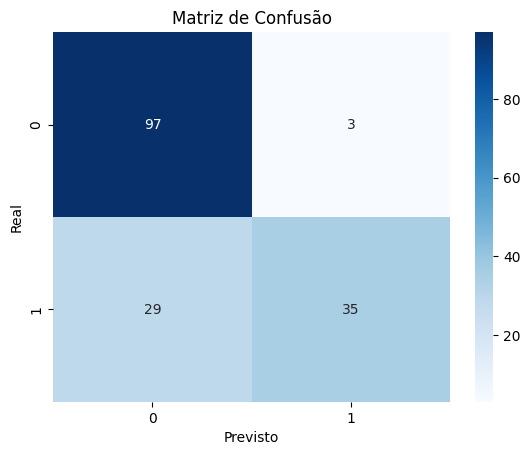

In [67]:
# 11. Avaliação
y_prep = modelo.predict(X_test)
print('\nRelatório de classificação:')
print(classification_report(y_test, y_prep))

print('\nMatriz de confusão:')
sns.heatmap(confusion_matrix(y_test, y_prep), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

In [69]:
# 12. Validação Cruzada com StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(modelo, X_scaled, y, cv=cv)
print('\nAcurácias (Stratified K-Fold:)', scores)
print('Acurácia média:', scores.mean())


Acurácias (Stratified K-Fold:) [0.79268293 0.81097561 0.78658537 0.84756098 0.87195122]
Acurácia média: 0.8219512195121952


In [71]:
# 13. Optimização de hipermarâmetros com GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10],
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print('\nMelhores hiperparâmetros:', grid.best_params_)
print('Melhor score:', grid.best_score_)


Melhores hiperparâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Melhor score: 0.8262317834836919


ROC AUC Score: 0.8595


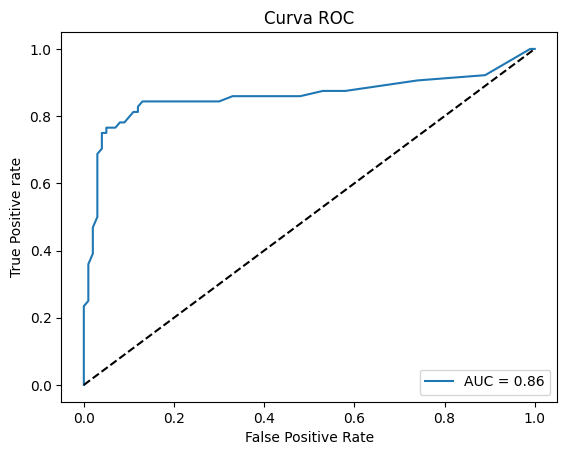

In [75]:
# 14. Teste com Curva ROC e AUC (se classificação binária)
from sklearn.metrics import roc_auc_score, roc_curve
if len(np.unique(y)) == 2:  # Verifica se é classificação binária
    y_proba = modelo.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    print(f'ROC AUC Score: {auc:.4f}')
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("Curva ROC apenas aplicável para classificação binária")


---
end of file